<a href="https://colab.research.google.com/github/redwineyards/autoencoders/blob/main/resnet_autoencoder/resnet_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
seed=42
torch.manual_seed(seed)
if device=='cuda': torch.cuda.manual_seed_all(seed)

root="/content/data"
trans=transforms.Compose([transforms.ToTensor()])
training_set=torchvision.datasets.MNIST(root=root,train=True,transform=trans,download=True)
test_set=torchvision.datasets.MNIST(root=root, train=False,transform=trans, download=True)

True


In [ ]:
num_epochs=20
learning_rate=1e-3
batch_size=128
train_loader=torch.utils.data.DataLoader(training_set,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)

In [ ]:
class EncResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super(EncResBlock,self).__init__()
    self.subblock_1=nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=(int)((kernel_size-1)/2)),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    self.subblock_2=nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=(int)((kernel_size-1)/2)),
        nn.BatchNorm2d(out_channels)
    )
    self.skip=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1)
    )
  
  def forward(self,x):
    residue=self.skip(x)
    out=self.subblock_1(x)
    #print(out.shape)
    out=self.subblock_2(out)+residue
    return F.relu(out).to(device)

In [ ]:
class DecResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super(DecResBlock,self).__init__()
    self.subblock_1=nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels, kernel_size, stride=1, padding=(int)((kernel_size-1)/2)),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    self.subblock_2=nn.Sequential(
        nn.ConvTranspose2d(out_channels, out_channels, kernel_size, stride=1, padding=(int)((kernel_size-1)/2)),
        nn.BatchNorm2d(out_channels)
    )
    self.skip=nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size=1,stride=1)
    )
  
  def forward(self,x):
    residue=self.skip(x)
    out=self.subblock_1(x)
    out=self.subblock_2(out)+residue
    return F.relu(out).to(device)

In [ ]:
class ResNet(nn.Module):
  def __init__(self):
    super(ResNet,self).__init__()
    self.enc1=nn.Sequential(
        nn.Conv2d(1,2,9),
        nn.ReLU()
    )
    self.enc2=EncResBlock(2,out_channels=4,kernel_size=9)
    self.enc3=nn.Sequential(
        nn.Conv2d(4,8,9),
        nn.ReLU()
    )
    self.enc4=EncResBlock(8,16,7)
    self.enc5=nn.Sequential(
        nn.Conv2d(16,32,7),
        nn.ReLU()
    )
    self.enc6=EncResBlock(32,64,5)
    self.enc7=nn.Sequential(
        nn.Conv2d(64,128,6),
        nn.ReLU()
    )
    self.dec1=nn.Sequential(
        nn.ConvTranspose2d(128,64,6),
        nn.ReLU()
    )
    self.dec2=DecResBlock(64,32,5)
    self.dec3=nn.Sequential(
        nn.ConvTranspose2d(32,16,7),
        nn.ReLU()
    )
    self.dec4=DecResBlock(16,8,7)
    self.dec5=nn.Sequential(
        nn.ConvTranspose2d(8,4,9),
        nn.ReLU()
    )
    self.dec6=DecResBlock(4,2,9)
    self.dec7=nn.Sequential(
        nn.ConvTranspose2d(2,1,9),
        nn.Sigmoid()
    )

  def forward(self,x):
    out=self.enc1(x)
    #print(out.shape)
    out=self.enc2.forward(out)
    out=self.enc3(out)
    out=self.enc4.forward(out)
    out=self.enc5(out)
    out=self.enc6.forward(out)
    out=self.enc7(out)
    out=self.dec1(out)
    out=self.dec2.forward(out)
    out=self.dec3(out)
    out=self.dec4.forward(out)
    out=self.dec5(out)
    out=self.dec6.forward(out)
    out=self.dec7(out)
    #print(out.shape)
    return out

In [ ]:
def train(model,train_loader,num_epochs,learning_rate):
  losses=[]
  optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
  lossfn=torch.nn.BCELoss().to(device)
  model.train()
  for epoch in range(num_epochs):
    for i,(images,_) in enumerate(train_loader):
      images=images.to(device)
      output=model.forward(images)
      loss=lossfn(output,images.float())
      losses.append(loss)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs,loss.item()))
    tens=[]
    tens_reconstr=[]
    plt.subplots(figsize=(50, 5))
    nos=[1,128,12370,111,2,244,44444,54695,14831,2299]
    for i in range(10):
      tens.append(training_set[nos[i]][0].reshape(-1,1,28,28))
      #tens1=torch.rand(1,1,28,28)*0.1
      #test1=np.squeeze(tens[i].numpy())
      with torch.no_grad():
        tens_reconstr.append(model.forward(tens[i].to(device)))
        #test_reconstr=np.squeeze(tens_reconstr[i].cpu().numpy())
      #fig, (ax1, ax2) = plt.subplots(1, 2)
      plt.subplot(1,20,2*i+1)
      plt.imshow(np.squeeze(tens[i].numpy()))
      plt.subplot(1,20,2*i+2)
      plt.imshow(np.squeeze(tens_reconstr[i].cpu().numpy()))
    plt.pause(1e-10)
  return losses

In [ ]:
def evaluate(model,test_loader):
  lossfn=torch.nn.BCELoss()
  model.eval()
  with torch.no_grad():
    total=0
    for i,(images,_) in enumerate(test_loader):
      images=images.to(device)
      output=model.forward(images)
      total+=lossfn(output,images.float())
    
    loss=total/len(test_loader)
    print("model test loss on MNIST test set:", loss.item())

Epoch [1/20], Loss: 0.1808


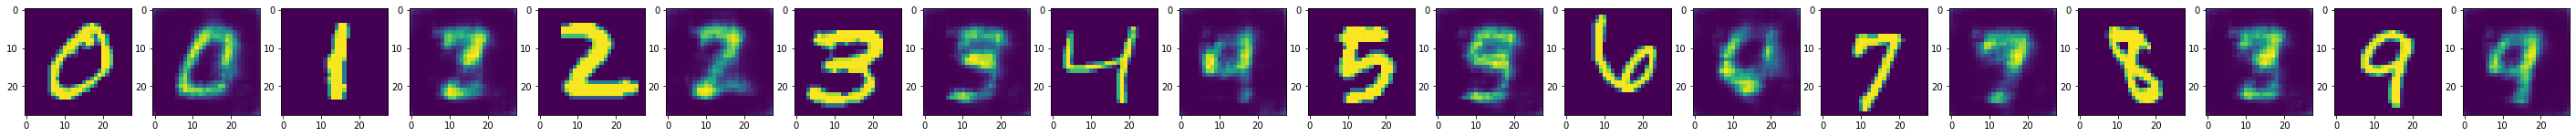

Epoch [2/20], Loss: 0.1250


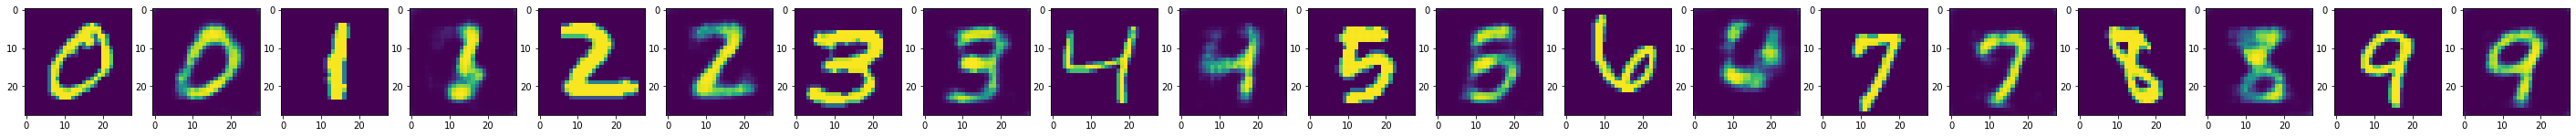

Epoch [3/20], Loss: 0.1133


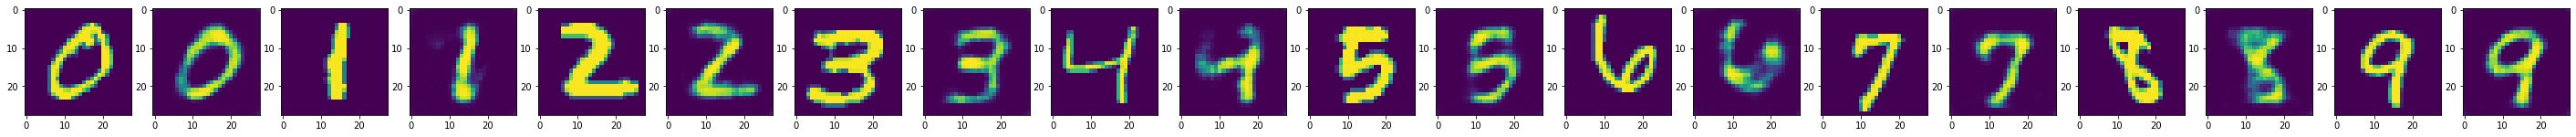

Epoch [4/20], Loss: 0.0973


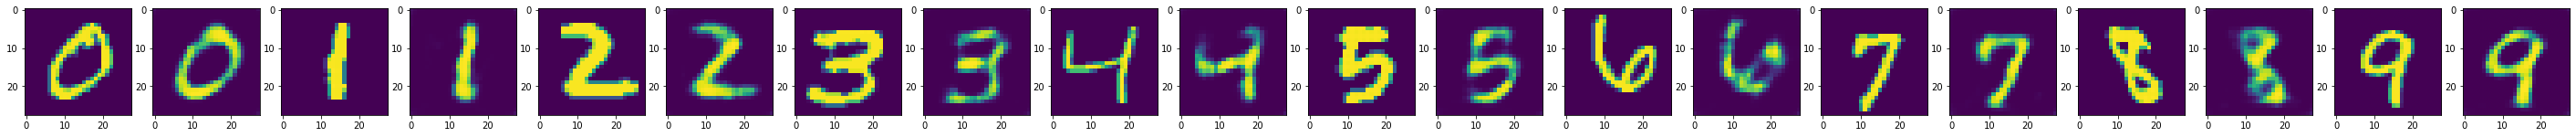

Epoch [5/20], Loss: 0.0981


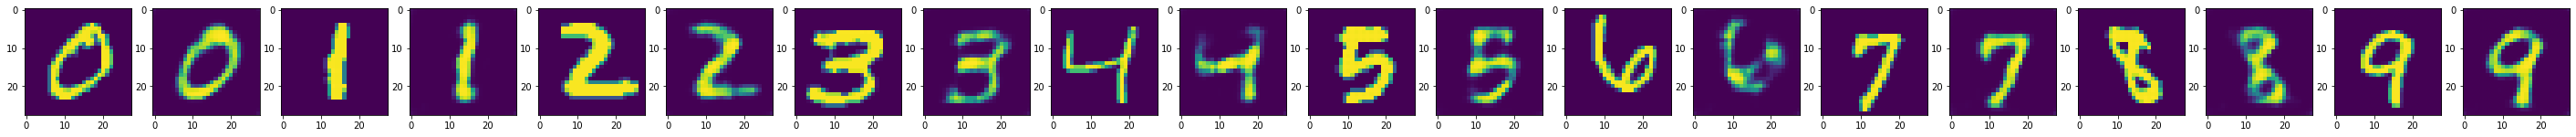

Epoch [6/20], Loss: 0.0910


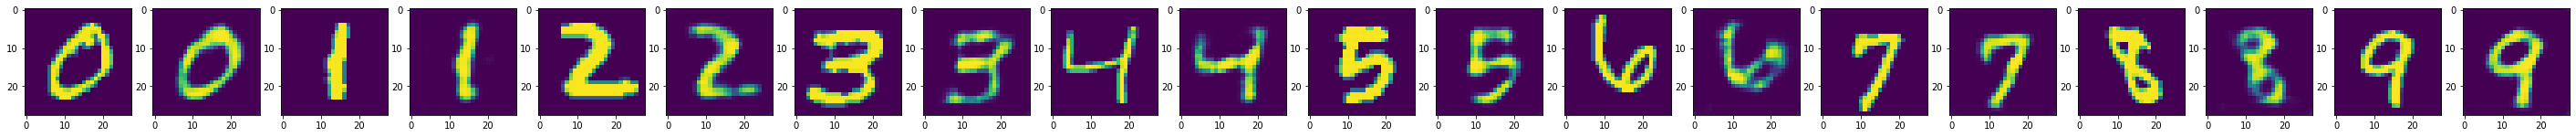

Epoch [7/20], Loss: 0.0918


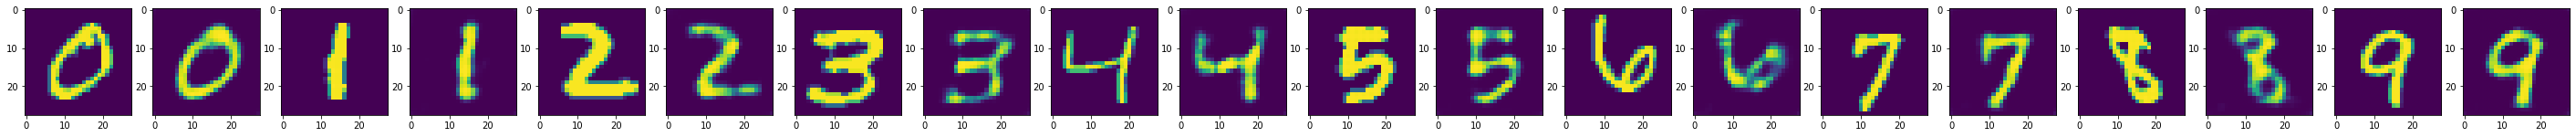

Epoch [8/20], Loss: 0.0893


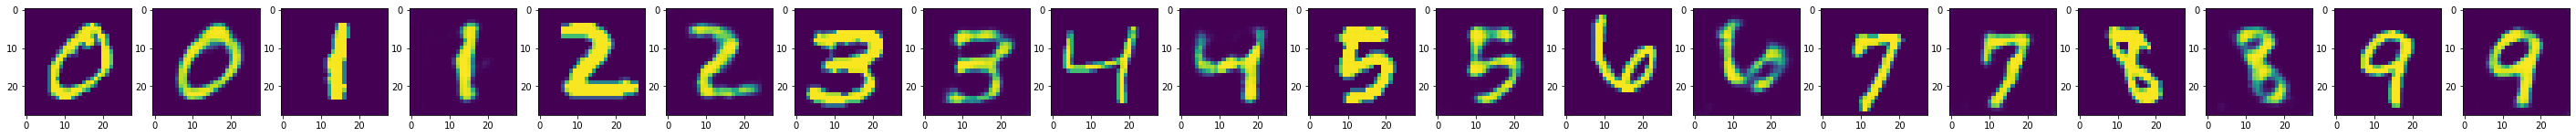

Epoch [9/20], Loss: 0.0835


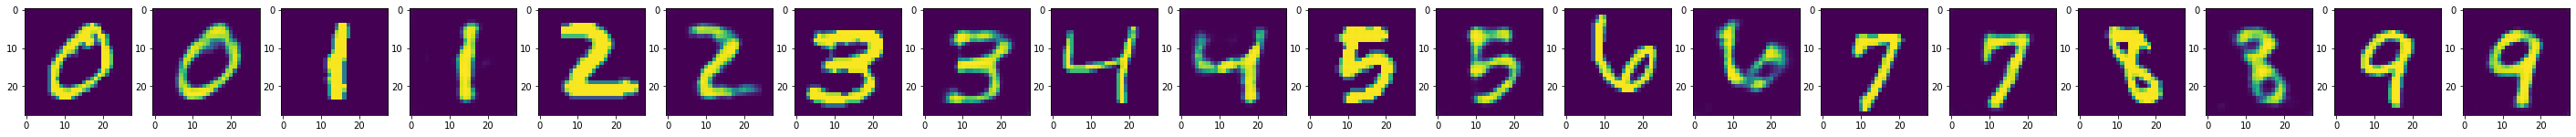

Epoch [10/20], Loss: 0.0832


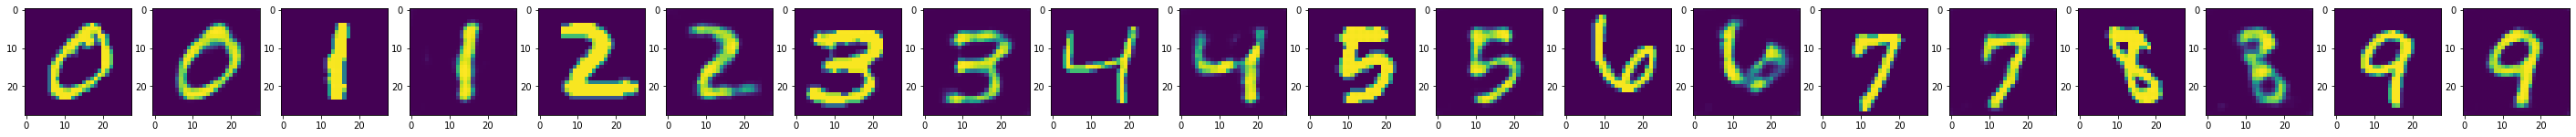

Epoch [11/20], Loss: 0.0879


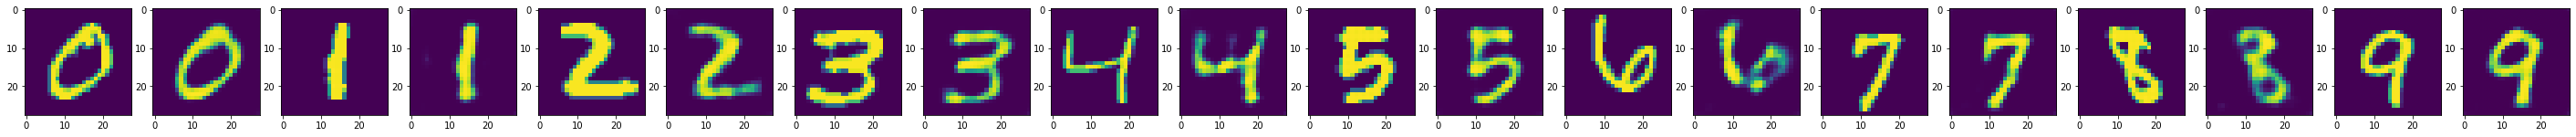

Epoch [12/20], Loss: 0.0857


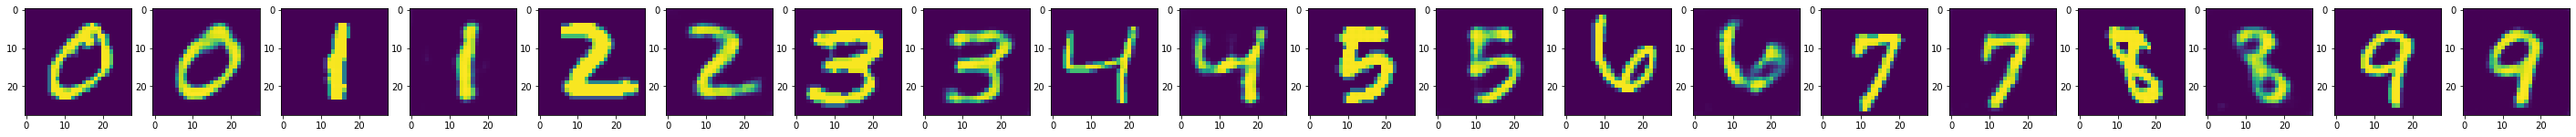

Epoch [13/20], Loss: 0.0803


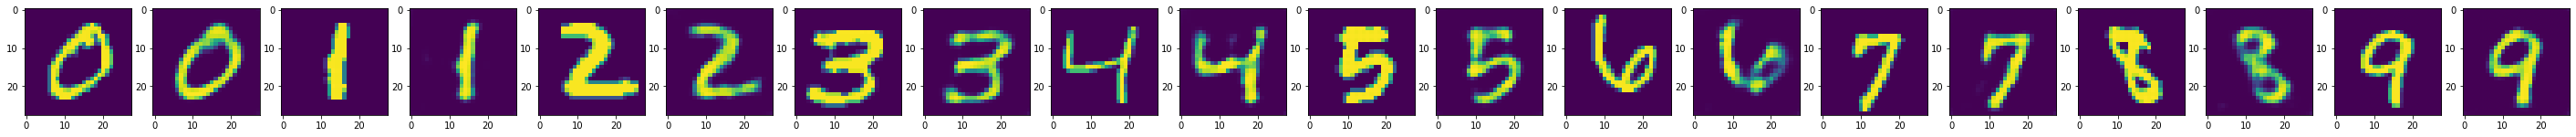

Epoch [14/20], Loss: 0.0798


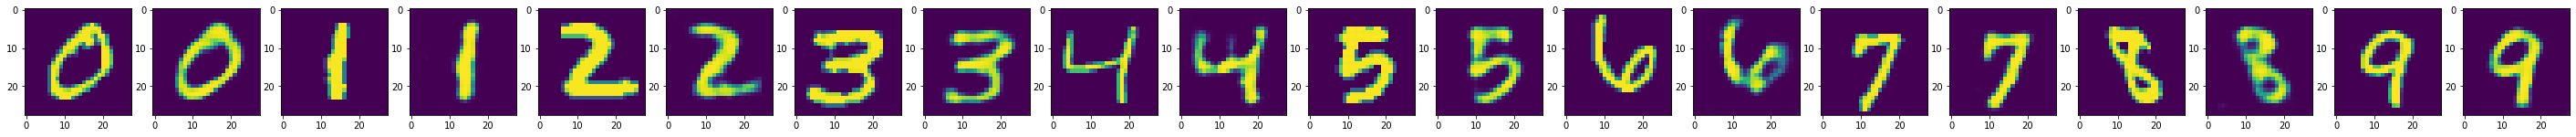

Epoch [15/20], Loss: 0.0835


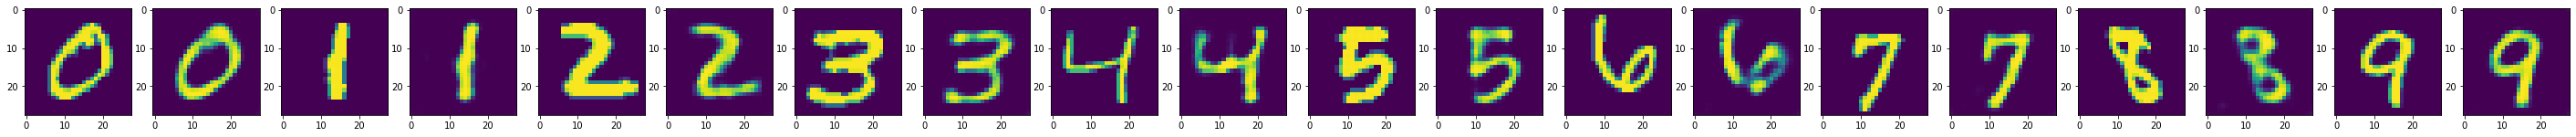

Epoch [16/20], Loss: 0.0820


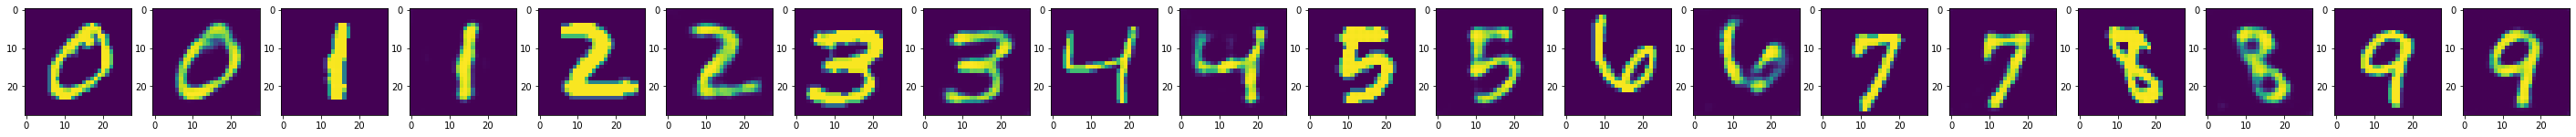

Epoch [17/20], Loss: 0.0854


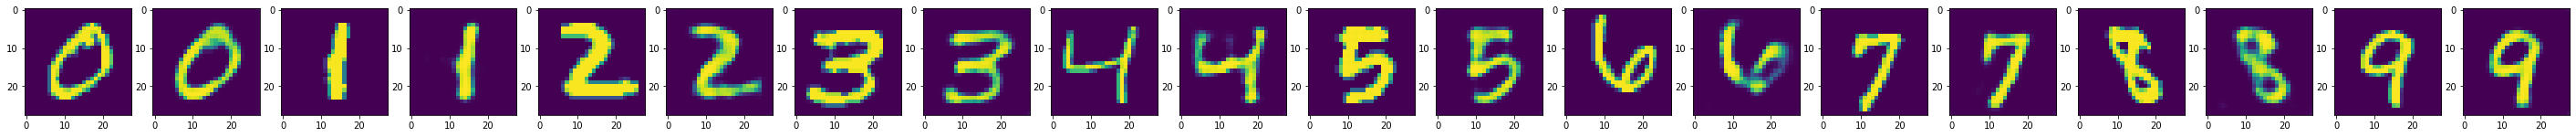

Epoch [18/20], Loss: 0.0766


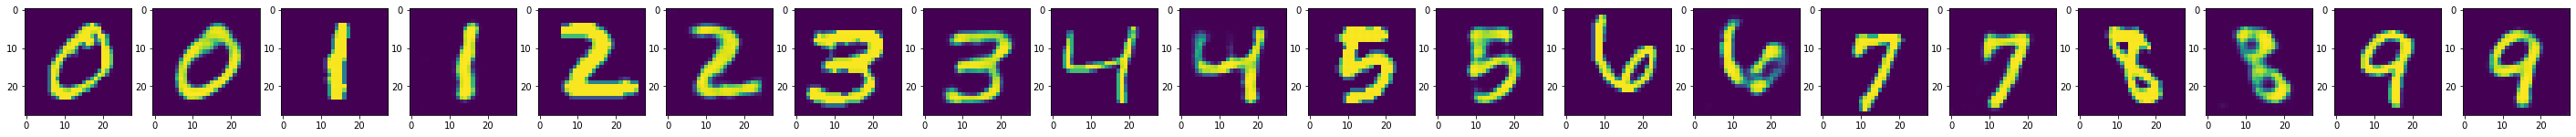

Epoch [19/20], Loss: 0.0773


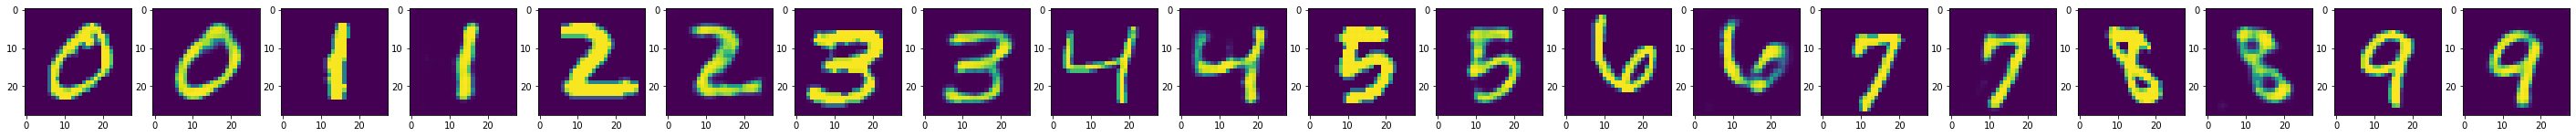

Epoch [20/20], Loss: 0.0815


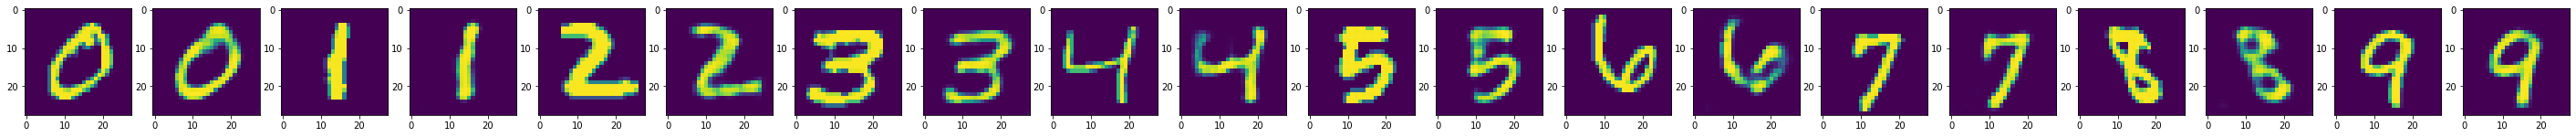

In [ ]:
model=ResNet().to(device)
losses=train(model,train_loader,num_epochs,learning_rate)

In [ ]:

evaluate(model,test_loader)

model test loss on MNIST test set: 0.08431471139192581


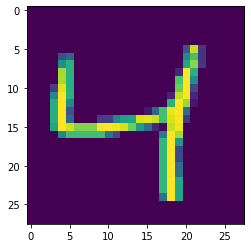

In [ ]:
tens1=training_set[2][0].reshape(-1,1,28,28)
#tens1=torch.rand(1,1,28,28)*0.1
test1=np.squeeze(tens1.numpy())
plt.imshow(test1)

In [ ]:
[1,128,12370,111,2,244,44444,54695,14831,2299]